# Import Libraries

In [1]:
#Import Libraries

#for reading and data-manipulation
import os
import numpy as np
import pandas as pd

In [2]:
#for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [3]:
#for data preprocessing
import time
from contractions import contractions_dict
import re
from collections import Counter
from wordcloud import STOPWORDS
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
# for ML model Implementation
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
from gensim.models.coherencemodel import CoherenceModel
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from bertopic import BERTopic
from sklearn.metrics import silhouette_score
import hdbscan
from sentence_transformers import SentenceTransformer
from umap import UMAP

/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
# warnings.simplefilter("ignore", category=SettingWithCopyWarning)


# Import CSV File

In [6]:

df = pd.read_csv('lenovoK8.csv', encoding='ISO-8859-1') # this is for the LenovoK8 dataset.
df.head()

,sentiment,review
0,1,Good but need updates and improvements
1,0,"Worst mobile i have bought ever, Battery is dr..."
2,1,when I will get my 10% cash back.... its alrea...
3,1,Good
4,0,The worst phone everThey have changed the last...


In [7]:
df = df.rename(columns={'review': 'brief_review'})


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14675 entries, 0 to 14674
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sentiment     14675 non-null  int64 
 1   brief_review  14675 non-null  object
dtypes: int64(1), object(1)
memory usage: 229.4+ KB


In [9]:

df = df[['brief_review', 'sentiment']].dropna()


In [10]:
df.head()

,brief_review,sentiment
0,Good but need updates and improvements,1
1,"Worst mobile i have bought ever, Battery is dr...",0
2,when I will get my 10% cash back.... its alrea...,1
3,Good,1
4,The worst phone everThey have changed the last...,0


In [11]:
# Handling missing values
df.isnull().sum()

brief_review    0
sentiment       0
dtype: int64

In [12]:
#handling duplicate values 
len(df[df.duplicated(subset=['brief_review'])])

1708

In [13]:
len(df[df.duplicated(subset=['sentiment'])])

14673

In [14]:
# Drop duplicate 
df_cleaned = df.drop_duplicates(subset = ["brief_review"])
print(df_cleaned.head())

                                        brief_review  sentiment
0             Good but need updates and improvements          1
1  Worst mobile i have bought ever, Battery is dr...          0
2  when I will get my 10% cash back.... its alrea...          1
3                                               Good          1
4  The worst phone everThey have changed the last...          0


In [15]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12967 entries, 0 to 14674
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brief_review  12967 non-null  object
 1   sentiment     12967 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 303.9+ KB


In [16]:
# #visualization for common words in entire documents
# # Chart - 4 visualization code

# # Combine all article content across categories
# combined_content = ' '.join(df_cleaned['brief_review'])

# #convert the whole content in lowercase
# combined_content = combined_content.lower()

# # Tokenize the combined content
# tokens = combined_content.split()

# # Filter out stopwords and non-alphanumeric words
# filtered_tokens = [word for word in tokens if word.isalpha() and word not in STOPWORDS]

# # Create a Counter to count word frequencies
# word_counter = Counter(filtered_tokens)

# # Choose the number of most common words to visualize
# num_common_words = 20
# common_words = word_counter.most_common(num_common_words)

# # Create a bar plot for common words
# plt.figure(figsize=(10, 6))
# plt.barh([word[0] for word in common_words], [count[1] for count in common_words], color='skyblue', edgecolor='black')
# plt.title('Common Words in Entire Documents')
# plt.xlabel('Word Frequency')
# plt.ylabel('Word')
# plt.tight_layout()

# # Display the plot
# plt.show()

# Text Preprocessing

In [17]:
# Expand Contraction

# Function to expand contractions using the contractions_dict
def expand_contractions(text):
    # Regular expression pattern to match contractions
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        expanded = contractions_dict.get(match.lower())
        return expanded

    expanded_text = contractions_pattern.sub(expand_match, text)
    return expanded_text

# Apply the expand_contractions function to the "brief_review" column
df_cleaned['brief_review'] = df_cleaned['brief_review'].apply(expand_contractions)

In [18]:
# Convert text in the "brief_review" column to lowercase
df_cleaned['brief_review'] = df_cleaned['brief_review'].str.lower()

In [19]:
# Remove Punctuations

# Function to remove punctuations from text
def remove_punctuations(text):
    # Create a translation table to remove punctuations
    translator = str.maketrans('', '', string.punctuation +'\n')

    # Apply the translation table to remove punctuations
    text_without_punctuations = text.translate(translator)
    return text_without_punctuations

# Apply the remove_punctuations function to the "brief_review" column
df_cleaned['brief_review'] = df_cleaned['brief_review'].apply(remove_punctuations)

In [20]:
# Function to remove URLs from text
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return re.sub(url_pattern, '', text)

# Function to remove words containing digits from text
def remove_words_with_digits(text):
    return ' '.join(word for word in text.split() if not any(char.isdigit() for char in word))

# Function to remove non-ASCII characters (special characters)
def remove_special_characters(text):
    # Replace non-ASCII characters with a space
    return re.sub(r'[^\x00-\x7F]+', ' ', text)

# Apply the remove_urls function to the "brief_review" column
df_cleaned['brief_review'] = df_cleaned['brief_review'].apply(remove_urls)

# Apply the remove_words_with_digits function to the "brief_review" column
df_cleaned['brief_review'] = df_cleaned['brief_review'].apply(remove_words_with_digits)

# Apply the remove_special_characters function to the "brief_review" column
df_cleaned['brief_review'] = df_cleaned['brief_review'].apply(remove_special_characters)

# Verify the cleaned data
df_cleaned['brief_review'].head()


0               good but need updates and improvements
1    worst mobile i have bought ever battery is dra...
2         when i will get my cash back its already ary
3                                                 good
4    the worst phone everthey have changed the last...
Name: brief_review, dtype: object

In [21]:
#THIS IS THE CODE TO REMOVE THE REVIEWS WITH WORD COUNT<=5
# Function to filter reviews based on word count
def filter_short_reviews(text, min_word_count=5):
    return len(text.split()) >= min_word_count

# Apply the filter function to the "brief_review" column and keep only reviews with word count >= 5
df_cleaned = df_cleaned[df_cleaned['brief_review'].apply(filter_short_reviews)]

# Verify the filtered data
df_cleaned['brief_review'].head()


0               good but need updates and improvements
1    worst mobile i have bought ever battery is dra...
2         when i will get my cash back its already ary
4    the worst phone everthey have changed the last...
5    only telling do not buy totally disappointedpo...
Name: brief_review, dtype: object

In [22]:
 # Remove Stopwords
# Download the list of stopwords if not already downloaded
nltk.download('stopwords')

# Get the list of English stopwords
stop_words = set(stopwords.words('english'))

# Add unnecessary words to the list of English stopwords
stop_unnecessary_words = stop_words.union(set(['mr', 'people', 'would', 'year', 'said', 'say', 'also', 'wale', 'could', 'chars']))


# Function to remove stopwords from text
def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if len(word)>2]
    filtered_words = [word for word in words if word.lower() not in stop_unnecessary_words]
    return ' '.join(filtered_words)

# Apply the remove_stopwords function to the "brief_review" column
df_cleaned['brief_review'] = df_cleaned['brief_review'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/binitkc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# Remove white spaces from the "brief_review" column
df_cleaned['brief_review'] = df_cleaned['brief_review'].str.replace('\s+', ' ', regex=True)

In [24]:
#Since BERTopic uses embeddings from transformer models (e.g., BERT), it naturally captures the semantics and context of words. 
# So, advanced preprocessing steps like tokenization, stemming, or lemmatization are usually unnecessary and can sometimes 
# reduce the quality of embeddings.

In [25]:
# Shuffle the data
df_shuffled = df_cleaned.sample(frac=1, random_state=42).reset_index(drop=True)
df_shuffled.head()

,brief_review,sentiment
0,best phone rate camera quality good,1
1,turbocharger working good,1
2,product good shipping disturbing,0
3,camera quality good tested feel problem phone ...,1
4,first time bad experience bad display quality ...,0


In [26]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10506 entries, 0 to 14674
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brief_review  10506 non-null  object
 1   sentiment     10506 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 246.2+ KB


# Fitting Best Model

In [27]:
# We need to convert the df (series) to list for passing to BERTopic.
sentenceList = df_cleaned["brief_review"].tolist()
samplesentenceList = sentenceList[1:10001]

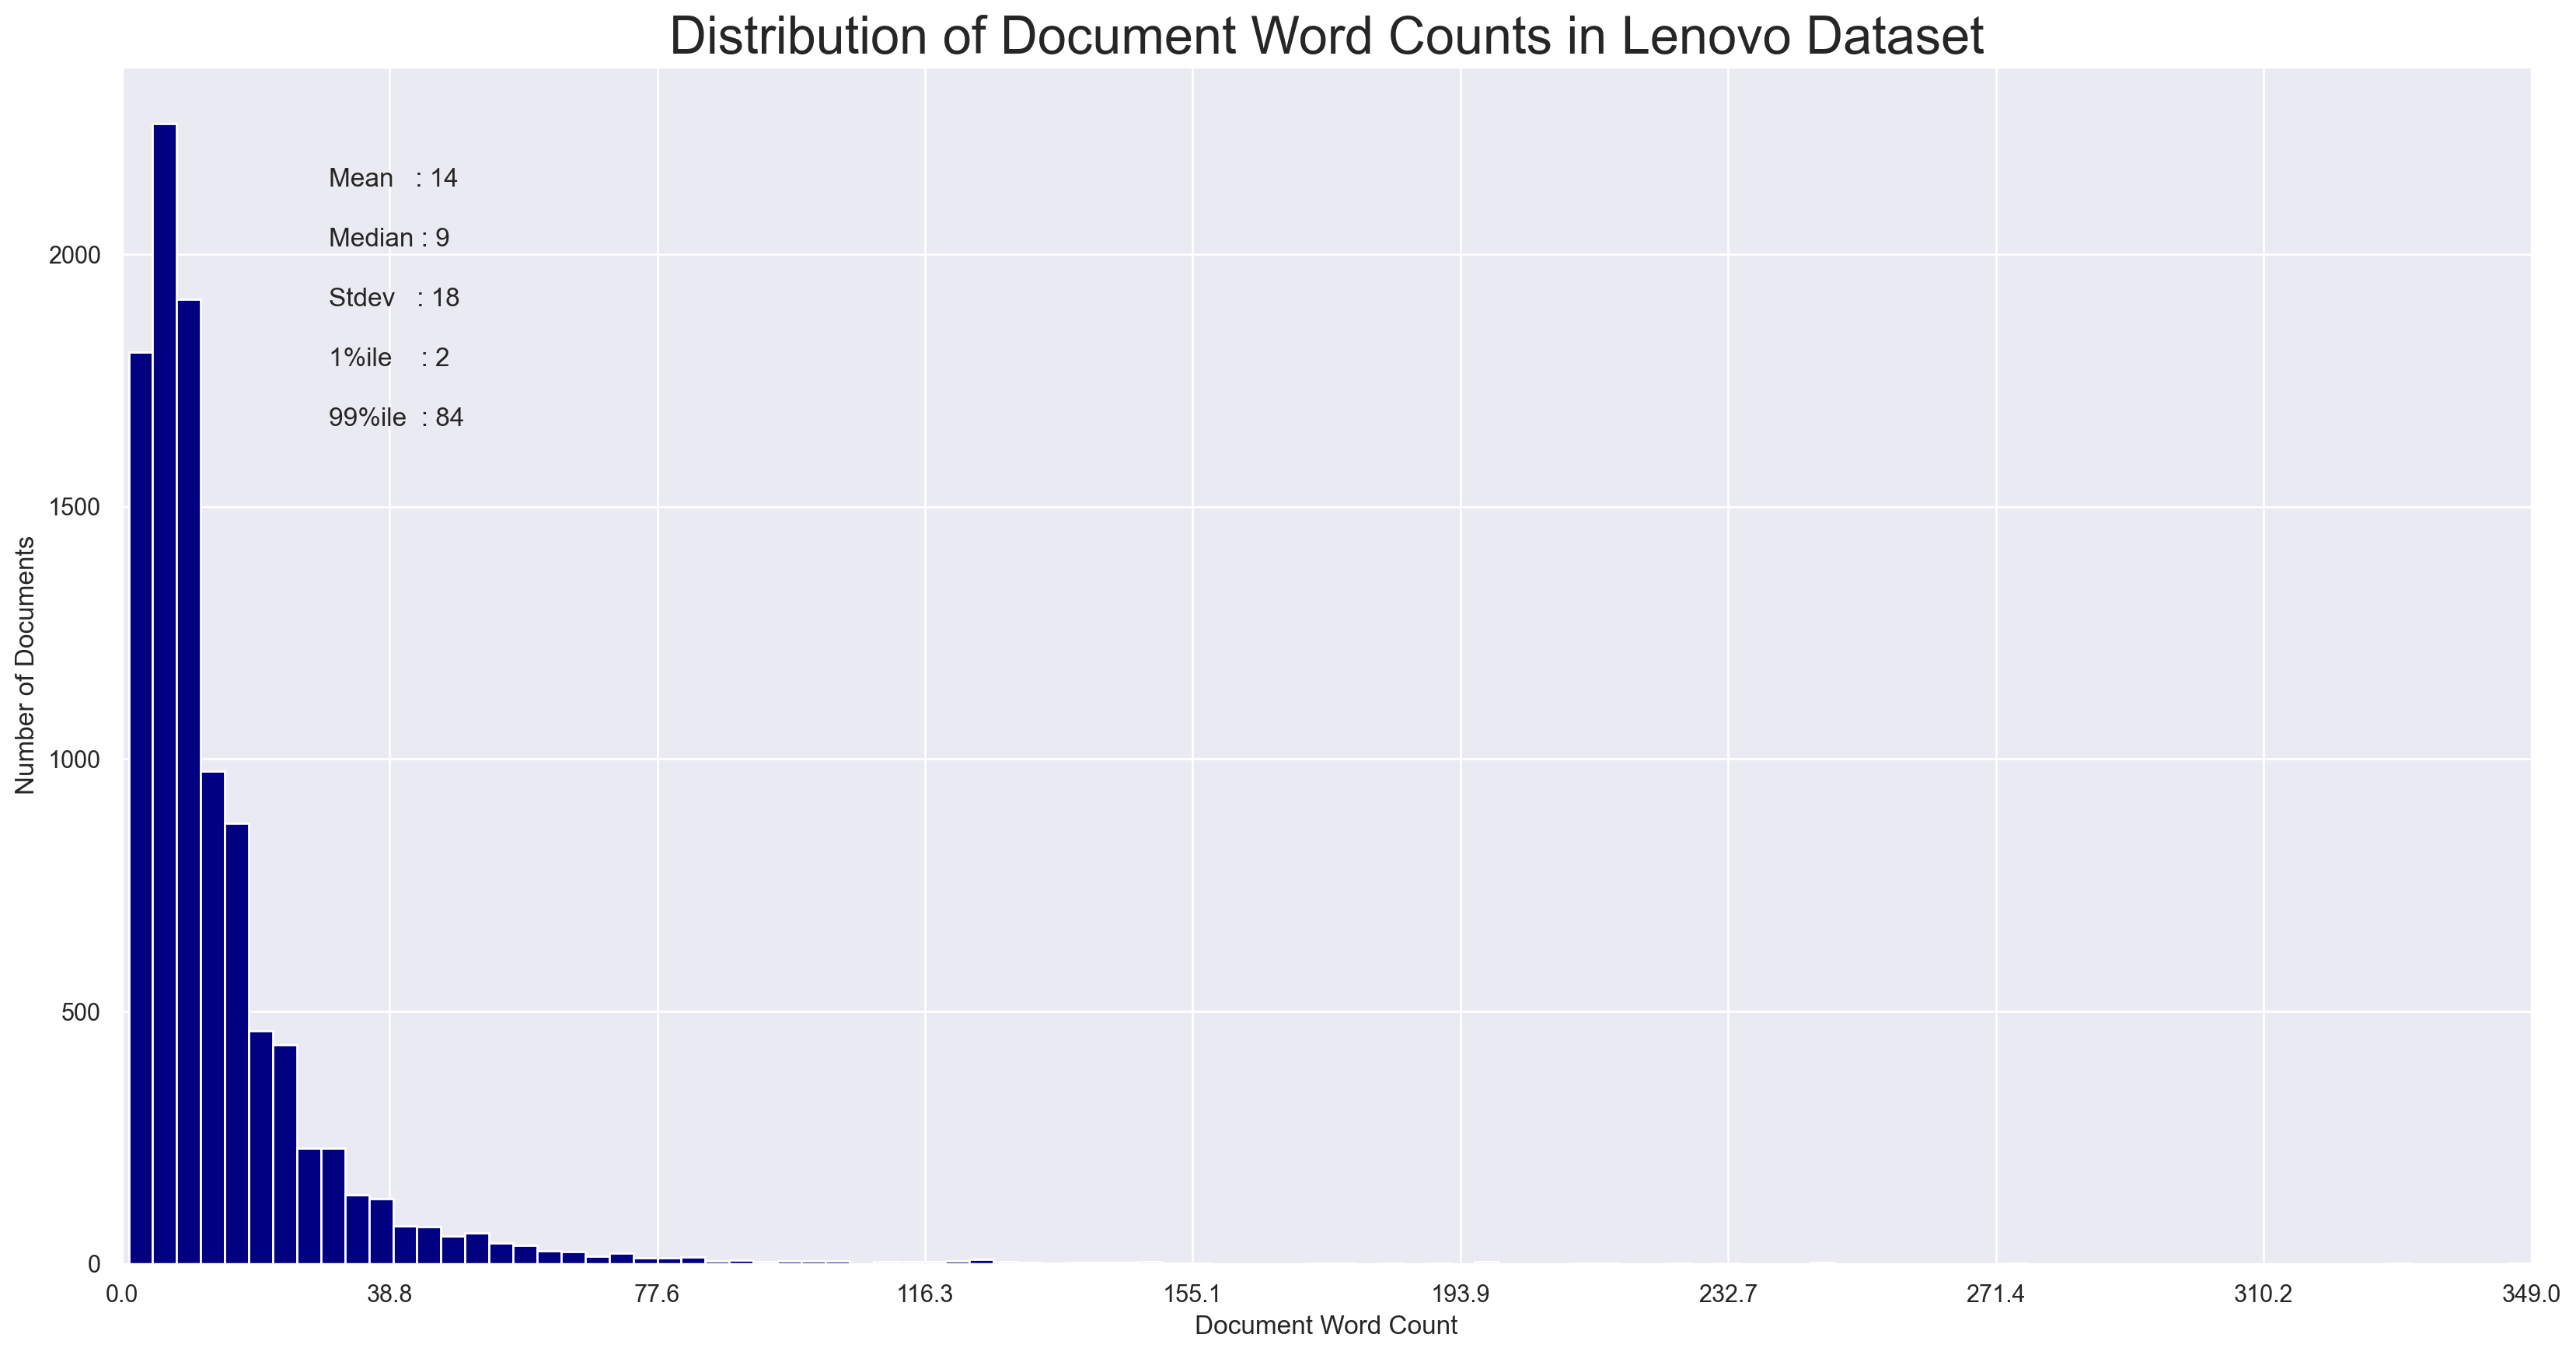

In [70]:
# Calculate the length of each sentence (word count)
sentence_lens = [len(sentence.split()) for sentence in samplesentenceList]

# Plot with larger figure size and higher resolution
plt.figure(figsize=(20, 10), dpi=200)  # Adjust as needed
plt.hist(sentence_lens, bins=100, color='navy')

# Add statistics as text annotations on the left side of the plot
plt.text(30, max(plt.gca().get_ylim()) * 0.9, f"Mean   : {round(np.mean(sentence_lens))}", fontsize=12)
plt.text(30, max(plt.gca().get_ylim()) * 0.85, f"Median : {round(np.median(sentence_lens))}", fontsize=12)
plt.text(30, max(plt.gca().get_ylim()) * 0.8, f"Stdev   : {round(np.std(sentence_lens))}", fontsize=12)
plt.text(30, max(plt.gca().get_ylim()) * 0.75, f"1%ile    : {round(np.quantile(sentence_lens, q=0.01))}", fontsize=12)
plt.text(30, max(plt.gca().get_ylim()) * 0.7, f"99%ile  : {round(np.quantile(sentence_lens, q=0.99))}", fontsize=12)

# Configure plot settings
plt.gca().set(xlim=(0, max(sentence_lens)), ylabel='Number of Documents', xlabel='Document Word Count')
plt.xticks(np.linspace(0, max(sentence_lens), 10))
plt.title('Distribution of Document Word Counts in Lenovo Dataset', fontdict={'size': 24})
plt.show()

In [28]:
# Step 1: Embed the Texts
embedding_model = SentenceTransformer('paraphrase-MiniLM-L3-v2')
embeddings = embedding_model.encode(samplesentenceList)

In [29]:
# Step 2: Dimensionality Reduction using UMAP
# Option 1: UMAP
umap_model = UMAP(n_components=5, random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [30]:
# KMeans Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(reduced_embeddings)
kmeans_silhouette = silhouette_score(reduced_embeddings, kmeans_labels)
print(f"KMeans Silhouette Score: {kmeans_silhouette}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


KMeans Silhouette Score: 0.3453318476676941


In [31]:
# HDBSCAN Clustering
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, cluster_selection_method='eom')
hdbscan_labels = hdbscan_model.fit_predict(reduced_embeddings)

# Note: Silhouette score works best when there are multiple clusters, and HDBSCAN may assign some points as noise (-1 label).
# Filter out noise points for Silhouette calculation
filtered_embeddings = reduced_embeddings[hdbscan_labels != -1]
filtered_labels = hdbscan_labels[hdbscan_labels != -1]

# Only calculate silhouette score if there are clusters
if len(set(filtered_labels)) > 1:
    hdbscan_silhouette = silhouette_score(filtered_embeddings, filtered_labels)
    print(f"HDBSCAN Silhouette Score: {hdbscan_silhouette}")
else:
    print("HDBSCAN resulted in only one cluster or noise.")

HDBSCAN Silhouette Score: 0.39446625113487244


In [41]:
# Hyper-parameter Tuning.


# Step 2: Define hyperparameter grids
# Step 2: Define hyperparameter grids
kmeans_params = {'n_clusters': [2, 3, 5, 7, 10]}
hdbscan_params = {
    'min_cluster_size': [5, 10, 15, 20],
    'min_samples': [1, 5, 8, 10],
    'cluster_selection_method': ['eom', 'leaf']
}


# Step 3: Evaluate KMeans
kmeans_results = []
for n_clusters in kmeans_params['n_clusters']:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(reduced_embeddings)
    score = silhouette_score(reduced_embeddings, labels)
    kmeans_results.append({'Algorithm': 'KMeans', 'n_clusters': n_clusters, 'Silhouette Score': score})

# Step 4: Evaluate HDBSCAN
hdbscan_results = []
for min_cluster_size in hdbscan_params['min_cluster_size']:
    for min_samples in hdbscan_params['min_samples']:
        for method in hdbscan_params['cluster_selection_method']:
            hdbscan_model = hdbscan.HDBSCAN(
                min_cluster_size=min_cluster_size,
                min_samples=min_samples,
                cluster_selection_method=method
            )
            labels = hdbscan_model.fit_predict(reduced_embeddings)
            # Skip noise points for Silhouette Score calculation
            if len(set(labels)) > 1:  # Ensure there are clusters
                score = silhouette_score(reduced_embeddings, labels)
                hdbscan_results.append({
                    'Algorithm': 'HDBSCAN',
                    'min_cluster_size': min_cluster_size,
                    'min_samples': min_samples,
                    'cluster_selection_method': method,
                    'Silhouette Score': score
                })

# Step 5: Combine results and display in a table
all_results = pd.DataFrame(kmeans_results + hdbscan_results)
sorted_results = all_results.sort_values(by='Silhouette Score', ascending=False)

# print(sorted_results)


In [42]:
print(sorted_results[0:10])


   Algorithm  n_clusters  Silhouette Score  min_cluster_size  min_samples  \
2     KMeans         5.0          0.345332               NaN          NaN   
4     KMeans        10.0          0.343287               NaN          NaN   
1     KMeans         3.0          0.325233               NaN          NaN   
3     KMeans         7.0          0.317916               NaN          NaN   
0     KMeans         2.0          0.278406               NaN          NaN   
5    HDBSCAN         NaN         -0.001557               5.0          1.0   
29   HDBSCAN         NaN         -0.009879              20.0          1.0   
13   HDBSCAN         NaN         -0.022090              10.0          1.0   
21   HDBSCAN         NaN         -0.027659              15.0          1.0   
31   HDBSCAN         NaN         -0.069139              20.0          5.0   

   cluster_selection_method  
2                       NaN  
4                       NaN  
1                       NaN  
3                       NaN  
0 

In [43]:
# Print the best result
best_result = sorted_results.iloc[0]
print("\nBest Result:")
print(best_result)


Best Result:
Algorithm                     KMeans
n_clusters                       5.0
Silhouette Score            0.345332
min_cluster_size                 NaN
min_samples                      NaN
cluster_selection_method         NaN
Name: 2, dtype: object


# Model Training 

In [44]:
# Define KMeans model with the best parameters #(e.g., n_clusters=5 from your tuning results)
kmeans_model = KMeans(
    n_clusters=5,  # Best parameter based on your tuning
    random_state=42
)



In [45]:
topic_model = BERTopic(
    embedding_model="paraphrase-MiniLM-L3-v2",  # or another pre-trained model
    hdbscan_model=kmeans_model,
    calculate_probabilities=True,
    verbose=True
)

In [46]:
topics, probs = topic_model.fit_transform(samplesentenceList)

2024-11-17 11:27:25,809 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2024-11-17 11:27:38,583 - BERTopic - Embedding - Completed ✓
2024-11-17 11:27:38,584 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-17 11:27:47,350 - BERTopic - Dimensionality - Completed ✓
2024-11-17 11:27:47,352 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-17 11:27:47,365 - BERTopic - Cluster - Completed ✓
2024-11-17 11:27:47,370 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-17 11:27:47,448 - BERTopic - Representation - Completed ✓


## Coherence Score

In [47]:
# Now retrieve topics and their words
from gensim.corpora.dictionary import Dictionary
topic_words = []
for topic_id in range(len(topic_model.get_topics())):
    # `get_topic` should return a list of word-score pairs for each topic
    topic = topic_model.get_topic(topic_id)
    if topic:  # Make sure the topic is not empty
        words = [word for word, _ in topic]
        topic_words.append(words)

# Tokenize the original documents for coherence calculation
tokenized_docs = [doc.split() for doc in samplesentenceList]

# Create a dictionary and calculate coherence
dictionary = Dictionary(tokenized_docs)
coherence_model = CoherenceModel(
    topics=topic_words,
    texts=tokenized_docs,
    dictionary=dictionary,
    coherence="c_v"
)
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/binitkc/ADS_FiNAL/ADS/lib/python3.9/site-packages/urllib3/__init__.py:35:

Coherence Score: 0.4534109795262681


## Topic Diversity

In [48]:
def topic_diversity_score(topic_model, top_n_words=10):
    all_words = []
    for topic in topic_model.get_topics().values():
        words = [word for word, _ in topic[:top_n_words]]
        all_words.extend(words)
    unique_words = set(all_words)
    return len(unique_words) / len(all_words)

diversity_score = topic_diversity_score(topic_model)
print(f"Topic Diversity Score: {diversity_score}")


Topic Diversity Score: 0.6


# Save the Model

In [49]:
# Specify the path where you want to save the model
model_path = "Trained_models/bertopic_lenovo_model"

# Save the trained BERTopic model
topic_model.save(model_path)


2024-11-17 11:28:14,617 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


# Load the Model

In [55]:
model_path = "Trained_models/bertopic_lenovo_model"

In [56]:
# Load the saved BERTopic model
topic_model = BERTopic.load(model_path)

In [57]:
print(f"Model calculate_probabilities: {topic_model.calculate_probabilities}")

Model calculate_probabilities: True


In [58]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,3015,0_battery_phone_good_charging,"[battery, phone, good, charging, camera, backu...","[battery problem phone, good phone good camera..."
1,1,2748,1_phone_mobile_amazon_good,"[phone, mobile, amazon, good, buy, product, wo...","[phone good working, note good phone, good pro..."
2,2,2498,2_camera_good_phone_quality,"[camera, good, phone, quality, screen, sound, ...","[nice phone camera flash quality good, camera ..."
3,3,1095,3_product_good_price_nice,"[product, good, price, nice, buy, note, best, ...","[product, good product price, good product]"
4,4,644,4_heating_phone_problem_good,"[heating, phone, problem, good, heat, issue, m...","[good phone heating issue good, good heating p..."


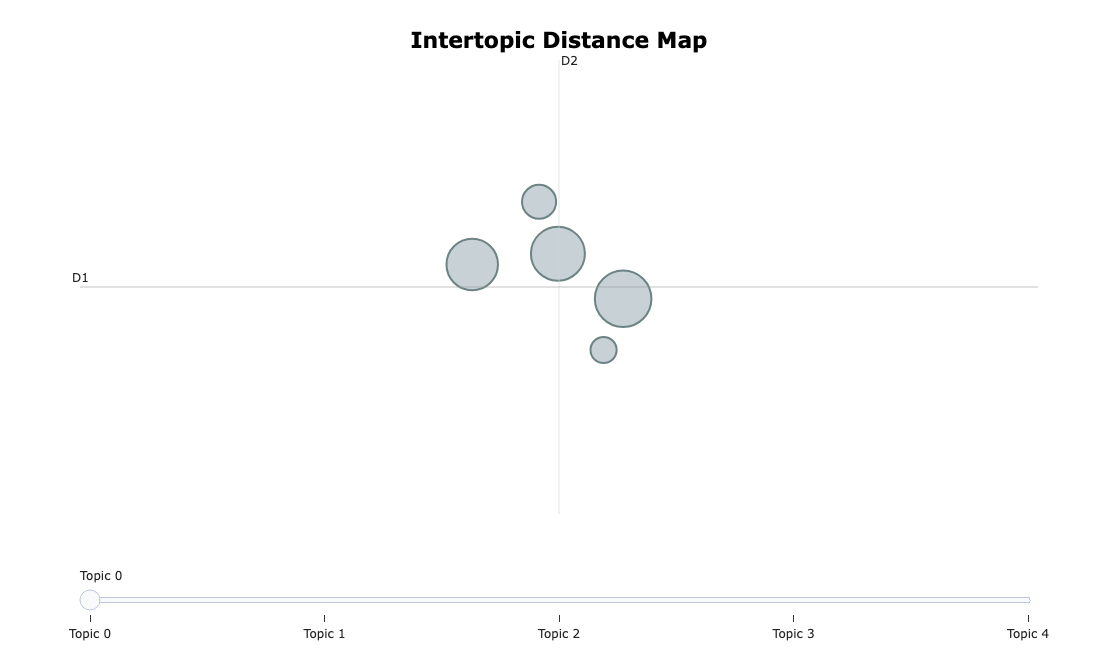

In [60]:
# Visualize topic similarity using a 2D representation
topic_model.visualize_topics()

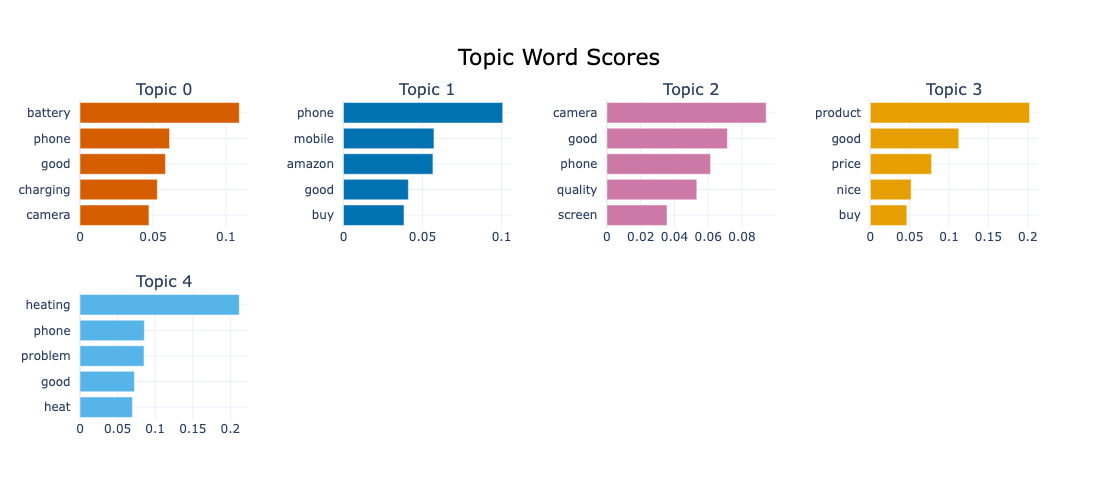

In [61]:
topic_model.visualize_barchart()

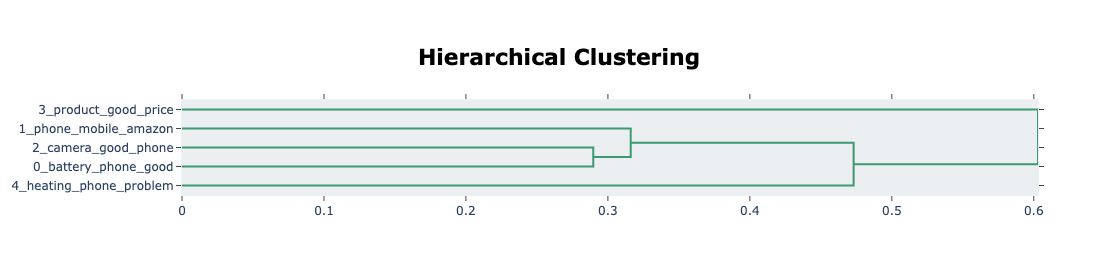

In [62]:

# Or, to visualize hierarchical relationships between topics
topic_model.visualize_hierarchy()

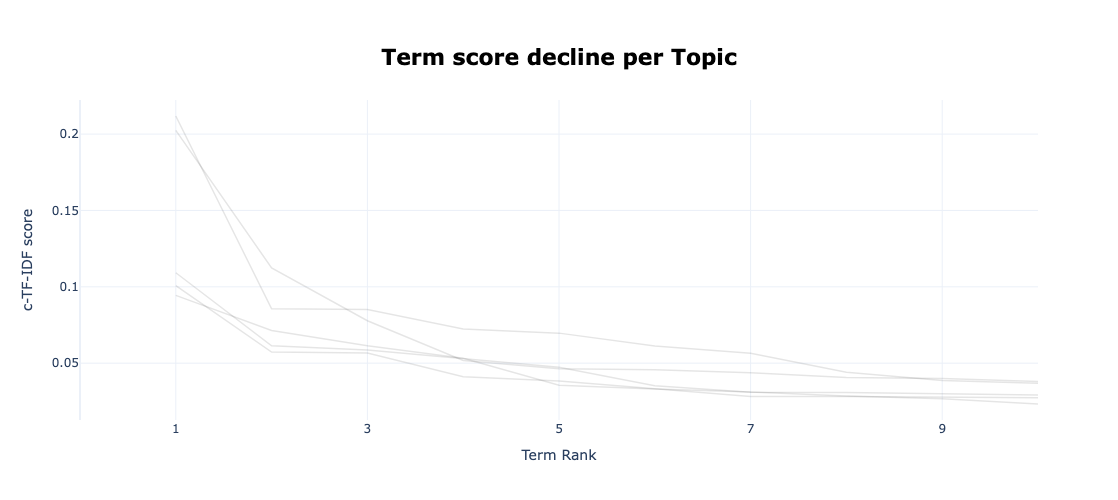

In [63]:
topic_model.visualize_term_rank()

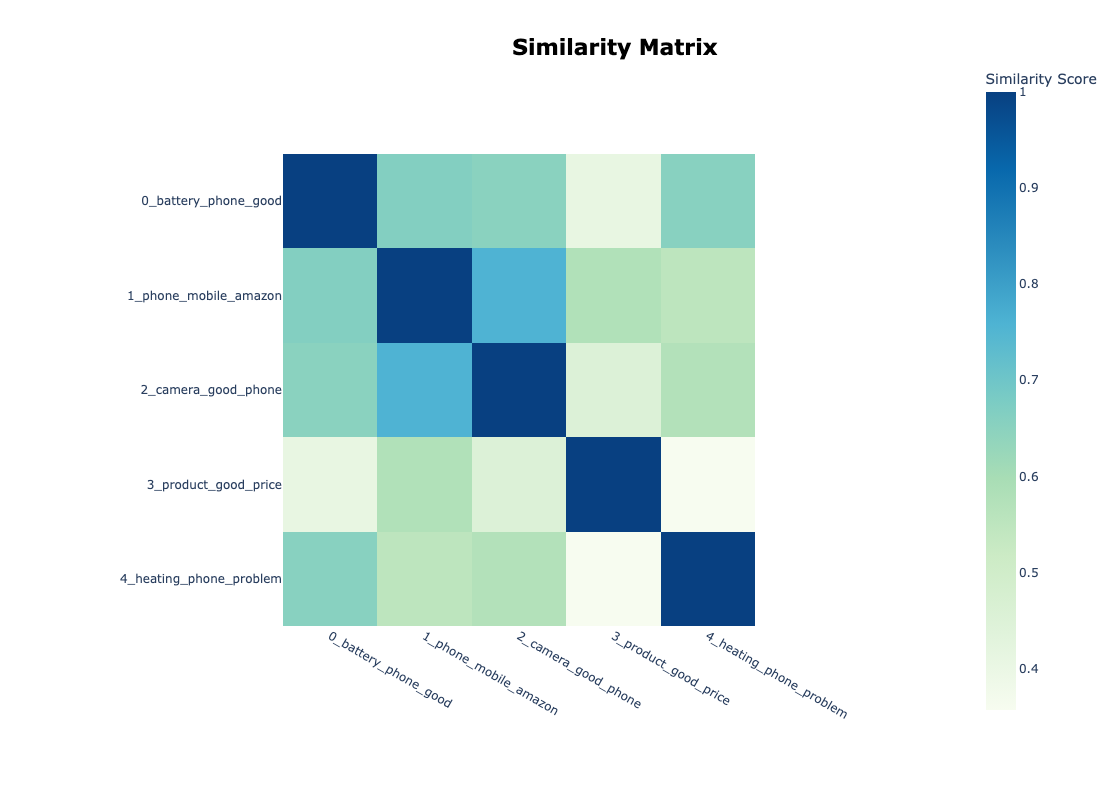

In [64]:
topic_model.visualize_heatmap()

In [74]:
# Testing with unseen dataset. 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-17 11:30:52,710 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-11-17 11:30:52,725 - BERTopic - Dimensionality - Completed ✓
2024-11-17 11:30:52,726 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-11-17 11:30:52,729 - BERTopic - Cluster - Completed ✓


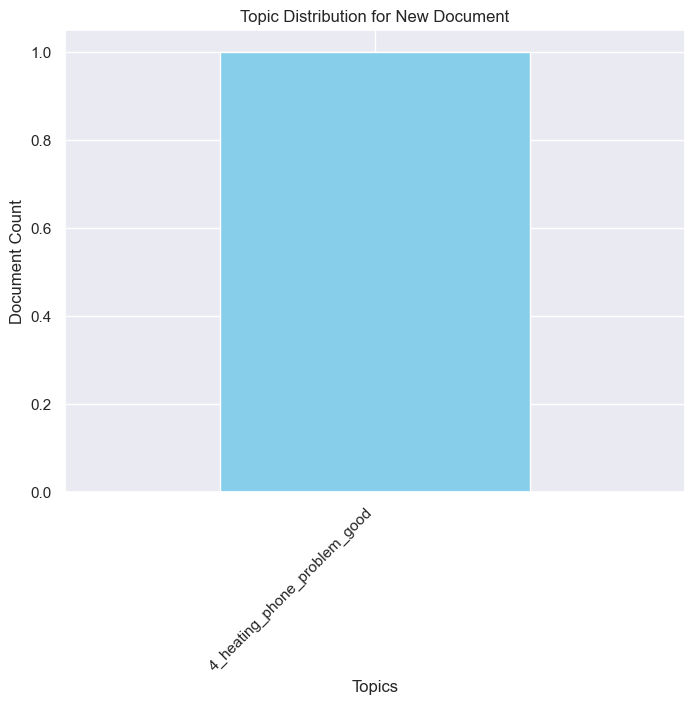

In [66]:

# Example new document
new_document = "The camera is good but the phone is heating  "

# Get the topic assignment (cluster label) for the new document
cluster_labels = topic_model.transform([new_document])  # This returns a list of lists
cluster_label = cluster_labels[0][0]  # Extract the first (and only) label from the list of lists

# Get the topic information (topics and their names)
topics = topic_model.get_topic_info()  # Get topic names
topic_labels = topics.set_index("Topic")["Name"].to_dict()

# Prepare data for visualization (mapping cluster labels to topic names)
assigned_topic = topic_labels.get(cluster_label, f"Topic {cluster_label}")

# Create a DataFrame to count the number of documents per topic (in this case, just one document)
topic_counts = pd.Series([assigned_topic]).value_counts()

# Plot bar chart
plt.figure(figsize=(8, 6))
topic_counts.plot(kind='bar', color='skyblue')
plt.title("Topic Distribution for New Document")
plt.xlabel("Topics")
plt.ylabel("Document Count")
plt.xticks(rotation=45, ha='right')
plt.show()
